In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

test = pd.read_json('test.json')
train = pd.read_json('train.json')

# Exploratory Data Anlysis #

In [2]:
train['ingredients'][0]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [3]:
train.loc[0]

id                                                         10259
cuisine                                                    greek
ingredients    [romaine lettuce, black olives, grape tomatoes...
Name: 0, dtype: object

In [4]:
# Cuisines Available
train['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

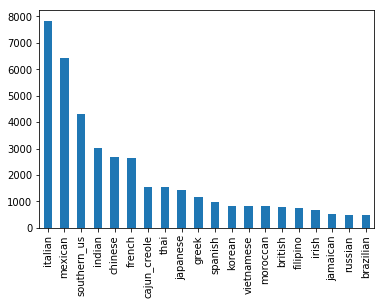

In [5]:
# Overall number of cuisines available with occurences
train['cuisine'].value_counts()
train['cuisine'].value_counts().plot.bar()

In [6]:
# Occurences of ingredients in the dataset
list_of_ingredients = [x for x in train['ingredients']]
list_of_ingredients

flat_list = []
for sublist in list_of_ingredients:
    for item in sublist:
        flat_list.append(item)
flat_list    
# flatten = lambda l: [item for sublist in l for item in sublist]

######################################
## Dictionary of ingredients counts ##
# import collections
# ingredients_dic = collections.Counter(flat_list)
# ingredients_dic = dict(ingredients_dic)
# ingredients_dic
######################################

# 50. Most used ingredients
pd.Series(flat_list).value_counts().head(50) # These ingredients may have lower predictive power as 
# they occur very often

salt                      18049
olive oil                  7972
onions                     7972
water                      7457
garlic                     7380
sugar                      6434
garlic cloves              6237
butter                     4848
ground black pepper        4785
all-purpose flour          4632
pepper                     4438
vegetable oil              4385
eggs                       3388
soy sauce                  3296
kosher salt                3113
green onions               3078
tomatoes                   3058
large eggs                 2948
carrots                    2814
unsalted butter            2782
ground cumin               2747
extra-virgin olive oil     2747
black pepper               2627
milk                       2263
chili powder               2036
oil                        1970
red bell pepper            1939
purple onion               1896
scallions                  1891
grated parmesan cheese     1886
sesame oil                 1773
corn sta

In [7]:
# Least used ingredients
least = pd.Series(flat_list).value_counts()
least[least==1] # 1759 ingredients only happen in one recpeie. They may have high predictive power 
#and overfit the data

sauce mix                 1
peaches in syrup          1
strawberry gelatin        1
filipino eggplant         1
spicy mayonnaise          1
                         ..
Azteca Flour Tortillas    1
gluten-free pie crust     1
cheese curds              1
sturgeon                  1
Knorr® Beef Bouillon      1
Length: 1759, dtype: int64

In [8]:
# When exploring the least frequent ingredients noticed some noise such as the ® sign in the data.
# There may be much more noise in the data. Need to get rid of them for model performance.
pd.Series(flat_list).value_counts().tail(50)
# Needs preprocessing and normalization

lipton recip secret golden onion soup mix    1
champagne grapes                             1
honey-flavored greek style yogurt            1
gluten free chicken broth                    1
coleslaw dressing                            1
chuck short ribs                             1
treviso radicchio                            1
leftover gravy                               1
chicken chorizo sausages                     1
chocolate ice cream mix                      1
bai cai                                      1
low sodium low fat pasta sauce               1
dark crème de cacao                          1
kha                                          1
cold coffee                                  1
non dairy sour cream                         1
satsuma juice                                1
Mexican lager beer                           1
mincemeat pie filling                        1
organic vegetable stock                      1
tuaca                                        1
macaroni and 

# Feature preprocessing #

In [9]:
## Feature preprocessing ##
import string
import re

translator = str.maketrans('', '', string.punctuation) # to remove punctuation
def preprocessing(data):
    trian_X = [x for x in data]
    train_X = [' '.join(x) for x in data]
    train_X = [x.split() for x in train_X]
    # print(train_X) # To view the overall features

    for sublist in train_X:
        for i in range(len(sublist)):
            sublist[i] = sublist[i].strip() # Strip spaces
            sublist[i] = sublist[i].lower() # Make lowercase
            sublist[i] = sublist[i].encode('ascii', 'ignore').decode('utf8') # Strip unicode
            sublist[i] = re.sub(r" ?\([^)]+\)", "", sublist[i]) # Dispose form additional info inside parenthesis
            sublist[i] = sublist[i].translate(translator) # Remove punctuations
    
    return train_X

train_X = preprocessing(train['ingredients'])
# train_X

# Machine Learning Model #

In [10]:
# Encode features and labels #
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.neighbors import KNeighborsClassifier


vectorizer = TfidfVectorizer(max_df=0.99)
X_train = vectorizer.fit_transform([str(i) for i in train_X])
le = LabelEncoder()

Y = [x for x in train['cuisine']]
y_train = le.fit_transform(Y)
# y_train

In [11]:
# SVM Model #
clf = SVC(C=3.55, cache_size=500, gamma=1)
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=1)
print("Accuracy SVM with Preprocessing: {score_mean:.2f}".format(score_mean=scores.mean()))

Accuracy SVM with Preprocessing: 0.81


In [16]:
# KNN Model #
neighbors = KNeighborsClassifier(n_neighbors=4)
scores = cross_val_score(neighbors, X_train, y_train, cv=5, n_jobs=1)
print("Accuracy KNN with Preprocessing: {score_mean:.2f}".format(score_mean=scores.mean()))

Accuracy KNN with Preprocessing: 0.72


In [17]:
# Predictions #
# Train the model once more to predict for Test data.
clf = SVC(C=3.55, cache_size=500, gamma=1)
clf.fit(X_train, y_train)

# test_X = test['ingredients'].values

test_X = preprocessing(test['ingredients'])
X_test = vectorizer.transform([str(i) for i in test_X])

predict = clf.predict(X_test)
Y_test = le.inverse_transform(predict)

pred_final = pd.DataFrame()
pred_final['id'] = test['id']
pred_final['cuisine'] = Y_test
pred_final.to_csv('submission.csv', index=False) # Predicted submission file